







## Data Preparation
This notebook is to load and clean up the data from Vancouver listings roughly from 2017-2019

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from IPython.display import Image
import plotly.express as px
import plotly.graph_objects as go
from data_utils import train_val_test_split, normalize_dataset
import pickle
from sklearn import preprocessing


**Step 1:** Load the data. The entire dataset can easily fit in memory, so no messing around with SQL. Just load it into a pandas dataframe.

In [2]:
conn = sqlite3.connect('../vancouver_data_series.db')
c = conn.cursor()
raw_df = pd.read_sql_query("SELECT * FROM 'vancouver'",conn)
conn.close()

First, let's select the columns we want to work with for now and drop the rest. We'll add more later, although it will reduce the size of the dataset.

In [3]:
print(raw_df.columns)
n_raw = len(raw_df.index)
df = raw_df[['date','id','latitude','longitude','price','area','bedrooms','unit_type','pets','furnished']]
df['date'] = pd.to_datetime(df['date'],utc=True)
len(df.index)

Index(['date', 'id', 'title', 'latitude', 'longitude', 'address',
       'date_available', 'price', 'area', 'neighbourhood', 'extras',
       'bedrooms', 'bathrooms', 'unit_type', 'parking', 'smoking', 'pets',
       'laundry', 'furnished', 'City', 'location'],
      dtype='object')


/home/bram/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



924653

## Removing Outliers
Now, we should remove outliers. These are values that don't make sense and are much more likely to errors than real data points. We'll plot the histogram of the variables to see that we have captured the majority of the distribution.

In [4]:
min_area = 200
max_area = 5000
min_price = 500 
# people often create listings that are just rooms, rather than whole apartments. We want to be aggressive about filtering those out.
# Potentially we'll take out some micro-units and social housing here, but it should be okay
max_price = 7000
max_bedrooms = 10

top_lat = 49.4
bot_lat = 49.0

the_west = -123.4
the_east = -121.5

df = df[df['latitude'] < top_lat]
df = df[df['latitude'] > bot_lat]

df = df[df['longitude'] < the_east]
df = df[df['bedrooms'] > the_west]


# start_date = June-01-2017
# end_date = Aug-01-2019

df = df[df['area'] > min_area] 
df = df[df['area'] < max_area]
df = df[df['price'] > min_price] 
df = df[df['price'] < max_price]
df = df[df['bedrooms'] < max_bedrooms]

# dates
start_date = pd.to_datetime("2017-06-15T10:00:00-07:00",utc=True)
stop_date = pd.to_datetime("2019-07-26T10:00:00-07:00",utc=True)
df = df[df['date'] > start_date]
df = df[df['date'] < stop_date]

# fit a distribution to a column and remove bottom 1% and top 1%. This will remove legitimate data points, but we don't care that much about them. The goal here is to model typical houses

from scipy.stats import lognorm, norm

def remove_outliers_std (dataframe,column,dist_name='norm',lower_bound=0.01,upper_bound=0.99):
    """
    Remove points which fall outside the centre of the distribution for named column.
    
    lower_bound - sets the percentile to cut below on the lower side (eg 1%)
    upper_bound - sets the percentile to cut above on the upper side (eg 99%)
    dist_name - which distribution to use. 'norm', 'lognorm'. This ought to work fine with any scipy rv_continuous distribution
    
    This is a good first-pass for data which we expect will be normally-distributed (or something like that)
    """
    distributions = {'norm': norm, 'lognorm': lognorm}
    dist = distributions[dist_name]
    data = dataframe[column].to_numpy()
    dist_params = dist.fit(data) # shape,std,mean
    lower_cutoff = dist.ppf(lower_bound, *dist_params)
    upper_cutoff = dist.ppf(upper_bound, *dist_params)
    x = np.linspace(lower_cutoff,upper_cutoff, 100)
    nbins = 80
    fig = px.histogram(dataframe,x=column,nbins=nbins)
    bin_size = (np.max(data) - np.min(data))/nbins
    amplitude = bin_size*len(data)
    y_pdf = amplitude*dist.pdf(x, *dist_params)
    fig.add_trace(go.Scatter(x=x,y=y_pdf,name=dist_name))
    fig.add_trace(go.Scatter(x=[lower_cutoff,lower_cutoff],y=[0,np.max(y_pdf)],name="Lower cutoff",line=dict(dash='dash')))
    fig.add_trace(go.Scatter(x=[upper_cutoff,upper_cutoff],y=[0,np.max(y_pdf)],name="Upper cutoff",line=dict(dash='dash')))
    #fig.show()
    print("Distribution Parameters: {}".format(dist_params))
    print("{:.2%} Cutoff: {}".format(lower_bound,lower_cutoff)) # the 1% cutoff
    print("{:.2%} Cutoff: {}".format(upper_bound,upper_cutoff)) # the 99% cutoff
    dataframe = dataframe[dataframe[column] >= lower_cutoff]
    dataframe = dataframe[dataframe[column] <= upper_cutoff]
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

df['price/area'] = df['price']/df['area']
df = remove_outliers_std(df,'price/area',dist_name='lognorm')
del df['price/area']


Distribution Parameters: (0.376636035680334, -0.3759102992443957, 2.7531251577882205)
1.00% Cutoff: 0.770402175345964
99.00% Cutoff: 6.236334008011405


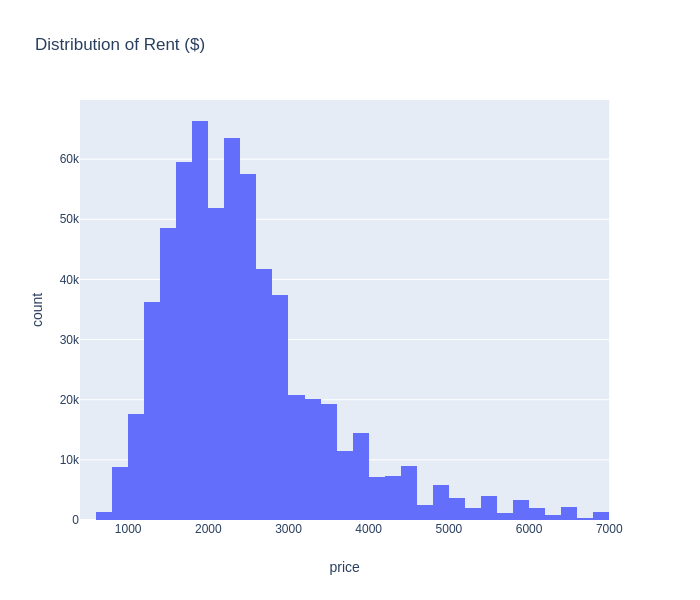

In [5]:
fig = px.histogram(df,x='price',nbins=50,title='Distribution of Rent ($)')
img = fig.to_image(format='png')
Image(img)

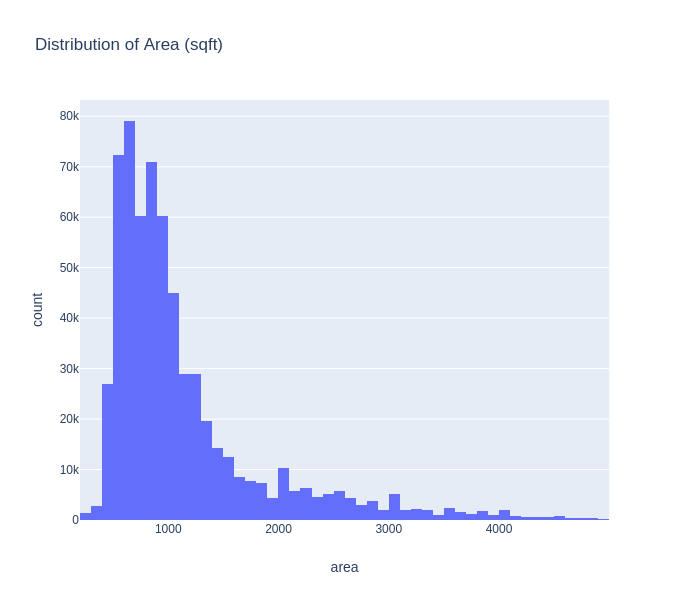

In [6]:
fig = px.histogram(df,x='area',nbins=50,title='Distribution of Area (sqft)')
img = fig.to_image(format='png')
Image(img)

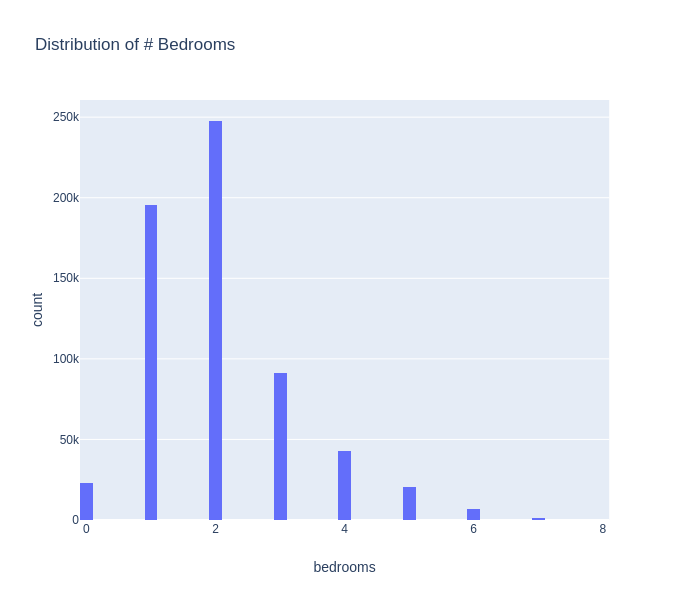

In [7]:
fig = px.histogram(df,x='bedrooms',nbins=50,title='Distribution of # Bedrooms')
img = fig.to_image(format='png')
Image(img)

## Remove Duplicate Listings
Duplicate listings are pretty common. We should do what we can to reduce them.

In [8]:
df = df.drop_duplicates(subset='id')
# I was worried that craigslist might re-use URLs but it doesn't appear to be the case

## Geographic outliers removal

Some locations are clearly wrong (eg in the ocean). Our outlier detection technique should be able to catch those.

In [9]:
from keys import mapbox_access_token 
from sklearn.ensemble import IsolationForest
from sklearn import svm

#X = df[['latitude','longitude','price','area','bedrooms']].to_numpy()

X = df[['latitude','longitude']].to_numpy()

# SVM produces better results than IsolationForest for my purpose

#X_sans = IsolationForest(n_estimators=150,random_state=0,behaviour='new',contamination=0.0005).fit_predict(X)
X_sans = svm.OneClassSVM(nu=0.0015, kernel="rbf").fit_predict(X)
df['outlier'] = X_sans

map_df = df[df['outlier'] == -1]
fig = px.scatter_mapbox(map_df,lon='longitude',lat='latitude')
fig.layout['mapbox']['accesstoken'] = mapbox_access_token 
# fig.show()

df = df[df['outlier']==1]
df = df.drop(columns='outlier')

## Deal with missing data
The next step is to make sure the dataset is complete. Missing data is extremely common on these postings. 
1. Area: Mandatory
2. Price: Mandatory
3. Lat/Long: Mandatory
4. ID: Mandatory
5. Date: Mandatory
6. Bedrooms: Mandatory
7. Unit Type: Mandatory
8. Pets: Assume no unless listed
9. Furnished: Assume no unless listed

In [10]:
# Enforce Mandatory Fields

s0 = len(df.index)
df = df.dropna(subset=['unit_type','bedrooms','latitude','longitude','id','date','area','price'])
s1 = len(df.index)
print("Required mandatory fields removes {:.2%}% of data".format((s0-s1)/s0))

# If Pets or Furnished is None, set to 0
df['pets'] = df['pets'].fillna(value=0)
df['pets'] = df['furnished'].fillna(value=0)

n_clean = len(df.index)
print("Data cleaning complete. Removed {:.2%}% of data".format((n_raw-n_clean)/n_raw))

print("Records:{}".format(n_clean))

Required mandatory fields removes 3.93%% of data
Data cleaning complete. Removed 66.86%% of data
Records:306414


## Save the data

Data will be saved to .pickle file. Don't scale or deal with categories, just hand it to user

In [11]:

df = df.drop(columns=['id']) # we really don't need the id
df = df.reset_index(drop=True)

#norm_df,unit_converters = normalize_dataset(df,return_converters=True)
#train, test = train_val_test_split(norm_df, 0.8, val_frac=0)

#train.to_pickle("train.pickle")
#test.to_pickle("test.pickle")
df.to_pickle("dataset.pickle")
#pickle.dump(unit_converters,open(r'unit_converters.pickle','wb'))